In [6]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import time

import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd

In [41]:
# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [31]:
# Transformations applied on the image data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5)]), p=0.5),
                                transforms.RandomHorizontalFlip()
                               ])                      

transform_pred = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224))])

# Loading the data set's
data_set = torchvision.datasets.ImageFolder(root="C:/Users/Vivek C Raman/Desktop/DL Competition/data/archive/train_resized", transform=transform)
pred_data = torchvision.datasets.ImageFolder(root="C:/Users/Vivek C Raman/Desktop/DL Competition/data/archive/val", transform=transform_pred)

# Splitting the data for testing and training using random split under torch
train_set, test_set =torch.utils.data.random_split(data_set, (2980, 746)) # Train:Test/80:20

# Image Data Loaders for training, testing and prediction
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2) 
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)
predloader = torch.utils.data.DataLoader(pred_data, batch_size=1, shuffle=False, num_workers=2)

classes = ('christmas_cookies', 'christmas_presents', 'christmas_tree', 'fireworks', 'penguin', 'reindeer', 'santa', 'snowman')

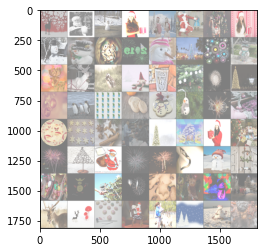

reindeer santa snowman christmas_presents snowman santa christmas_tree christmas_presents snowman snowman christmas_cookies fireworks snowman christmas_tree fireworks snowman reindeer reindeer penguin santa snowman christmas_tree fireworks christmas_tree christmas_tree penguin christmas_presents christmas_cookies christmas_cookies snowman fireworks christmas_tree santa christmas_cookies christmas_cookies christmas_presents christmas_tree christmas_tree christmas_presents christmas_presents fireworks christmas_tree santa fireworks fireworks christmas_cookies snowman christmas_tree christmas_presents snowman christmas_tree fireworks christmas_cookies christmas_tree snowman christmas_tree reindeer reindeer christmas_cookies reindeer reindeer christmas_tree snowman christmas_cookies


In [32]:
# function to show the image from the data loader
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Retrives some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Outputs the images
imshow(torchvision.utils.make_grid(images))
# Outputs the labels of the correspoding images
print(' '.join('%5s' % classes[labels[j]] for j in range(64)))

In [33]:
# The pre-trained model
vgg = models.vgg19_bn(pretrained=True)

# Modified the last layer of the classifer by changing the classes to 8 
vgg.classifier[6].out_features = 8

# Freeze convolution weights
for param in vgg.features.parameters():
    param.requires_grad = False

# Sends the model to the device (CPU/GPU)
vgg.to(device)


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to C:\Users\Vivek C Raman/.cache\torch\hub\checkpoints\vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:50<00:00, 11.5MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [35]:
# Optimizer defined
optimizer = optim.SGD(vgg.classifier.parameters(), lr=0.01, momentum=0.9)

# Loss function defined
lossfn = nn.CrossEntropyLoss()

In [37]:
# Function for training
def fit(model, train_dataloader, epoch, n_epochs):

    model.train()  # puts the model to training mode

    train_running_loss = 0.0
    train_running_correct = 0

    # Prints the number of epochs
    print(f'Epoch {epoch+1}/{n_epochs}')

    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()  # set the gradients to zero before starting to do backpropragation
        output = model(data)
        loss = lossfn(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1) # takes the highest val in an array and removes the rest, also returns the index of the highest value
        train_running_correct += (preds == target).sum().item()
        loss.backward() # computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x
        optimizer.step() # updates the value of x using the gradient x.grad

    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

In [38]:
# Validation/test function
def validate(model, test_dataloader):
    
    model.eval() # Puts the model to testing mode, Dropout layer inactive and BN layer to testing mode
    
    val_running_loss = 0.0
    val_running_correct = 0
    
    for i, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = lossfn(output, target)  
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    print('Validation Loss: ',val_loss , '  Validation Acc: ', val_accuracy)
    
    return val_loss, val_accuracy

In [39]:
# Epoch
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []

start = time.time()
n_epochs = 12  # Number of epochs

for epoch in range(n_epochs):
    train_epoch_loss, train_epoch_accuracy = fit(vgg, trainloader, epoch, n_epochs)
    val_epoch_loss, val_epoch_accuracy = validate(vgg, testloader)
    
    # save the whole model
    torch.save(vgg16, 'entire_model_ep' + str(epoch+1) + '.pt')
    
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

end = time.time()

print((end-start)/60, 'minutes')

Epoch 1/12


KeyboardInterrupt: 

In [ ]:
# Train/Validation accuracy plot
plt.figure(figsize=(10, 7))

plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()

plt.savefig('accuracy.png')
plt.show()

In [ ]:
# Train/Validation loss plot
plt.figure(figsize=(10, 7))

plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()

plt.savefig('loss.png')
plt.show()

In [ ]:
# Load the model with good characteristics
model = torch.load('entire_model_ep9.pt')
model.to(device)

In [ ]:
# Function for prediction
def prediction(model, predloader):
    
    model.eval()  # Puts the model to test/prediction mode (dropout layer inactive)
    
    result = {}
    
    for count, data in enumerate(predloader):
        data = data[0].to(device)
        output = model(data)
        _,preds = torch.max(output.data, 1)
        sample_fname, _ = predloader.dataset.samples[count]
        result[sample_fname[26:-4]] = preds[0].item() 
    return result
        

In [ ]:
# Calling the prediction function and passing the model and data loader
pred = prediction(model, predloader)
print(pred)

In [ ]:
# Saves the prediction data in to a csv file
with open('predictions.csv', 'w') as f:
    writer = csv.DictWriter(f, fieldnames=["Id", "Category"])
    writer.writeheader()
    [f.write('{0},{1}\n'.format(key, value)) for key, value in a.items()]